<a href="https://colab.research.google.com/github/isakdiaz/PlantNet_MobileNetV2/blob/main/PlantNet_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Google Drive

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import Tensorflow and other things

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pprint
import json
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score


import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image

## Check you are running on a TPU Or...


In [68]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('✅ Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  print("❌ No TPU Found! At the top click Runtime -> Change Runtime Type -> Hadrware Accelerator -> TPU")

❌ No TPU Found! At the top click Runtime -> Change Runtime Type -> Hadrware Accelerator -> TPU


##  Check if you are running on a GPU

In [69]:
# Check if running on GPU
import tensorflow as tf
gpu_location = tf.test.gpu_device_name()
if gpu_location:
  print("✅ GPU found at " + gpu_location)
else:
  print("❌ No GPU Found!. At the top click Runtime -> Change Runtime Type -> Hadrware Accelerator -> GPU")

✅ GPU found at /device:GPU:0


## Version Notice
This code assumes you are using tensorflow 2.0 or later and python 3.6 or later

In [ ]:
print("Tensorflow version is " + tf.__version__)
print("Numpy version is " + np.__version__)

In [ ]:
!pip install git+https://github.com/tensorflow/docs


In [ ]:
import tensorflow_docs as tdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [ ]:
# Place the plantnet zipped file in a folder called plantnet on your Google Drive directory
# Unzips files from google drive to google colab
!unzip /content/drive/MyDrive/plantnet/plantnet_300K.zip

In [ ]:
# Check file unzipped properly and is 31GB
!du -hs plantnet_300K/

In [ ]:
ls plantnet_300K/

In [ ]:
 # Check species classes vs folder names
FOLDER_TO_CLASS_JSON = "plantnet_300K/plantnet300K_species_names.json"

with open(FOLDER_TO_CLASS_JSON) as f:
  class_dict = json.load(f)
class_list = list(class_dict.values())

print(class_list)
#cat plantnet_300K/plantnet300K_species_names.json

# Create Datasets for training process
## Pick a Method






In [142]:
SEED = 123
IMAGE_SIZE = (524, 224)
BATCH_SIZE = 32

train_folder = "plantnet_300K/images_train/"
validation_folder = "plantnet_300K/images_val/"
test_folder = "plantnet_300K/images_test/"

# Method 1
Smart Resize already implemented, but is missing Data Augmentation


In [145]:
AUTO = tf.data.experimental.AUTOTUNE
PREPROCESS = True
BATCH_SIZE = 256

train_dataset_raw = tf.keras.preprocessing.image_dataset_from_directory(
    "plantnet_300K/images_train/", labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, seed=SEED,
    interpolation='bilinear', follow_links=False, smart_resize=True
)
val_dataset_raw = tf.keras.preprocessing.image_dataset_from_directory(
    "plantnet_300K/images_val/", labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=IMAGE_SIZE,
     shuffle=True, seed=SEED,
    interpolation='bilinear', follow_links=False, smart_resize=True
)

test_dataset_raw = tf.keras.preprocessing.image_dataset_from_directory(
    "plantnet_300K/images_test/", labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=IMAGE_SIZE,
     shuffle=True, seed=SEED,
    interpolation='bilinear', follow_links=False, smart_resize=True
)

@tf.function
def process_dataset(image, label):
  # image = tf.image.resize(image, (224, 224))
  # image = preprocess_input(image)
  image = image/127.0 - 1 #normalize around -1 to +1
  return(image, label)

train_dataset = train_dataset_raw.map(process_dataset, num_parallel_calls=AUTO)
val_dataset = val_dataset_raw.map(process_dataset, num_parallel_calls=AUTO)
test_dataset = test_dataset_raw.map(process_dataset, num_parallel_calls=AUTO)

Found 243916 files belonging to 1081 classes.
Found 31118 files belonging to 1081 classes.
Found 31112 files belonging to 1081 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


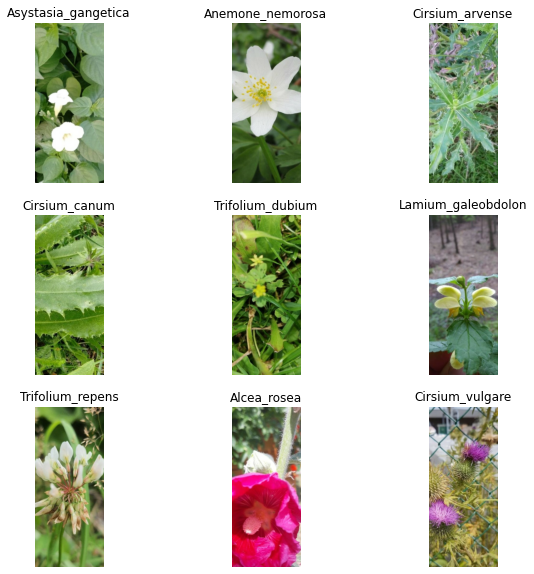

In [146]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        image = (images[i].numpy() + 1)/ 2.0
        plt.imshow(image)
        plt.title(class_list[np.argmax(labels[i])])
        plt.axis("off")

# Method 2

Data Augmentation included but is missing Smart Resize



In [143]:
# By default flow_from_directory shuffles data
train_datagen = ImageDataGenerator(
        rescale=1./255,
        # rotation_range=45,
        # width_shift_range=0.1,
        # height_shift_range=0.1,
        # brightness_range=(0.3,1.0),
        # shear_range=0.2,
        # zoom_range=0.2,
        horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=IMAGE_SIZE,
        batch_size=batch_size,
        class_mode='categorical')

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
        validation_folder,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical')

train_dataset = train_generator
val_dataset = validation_generator

Found 243916 images belonging to 1081 classes.
Found 31118 images belonging to 1081 classes.


Image Sizes: 32
Lathraea_squamaria


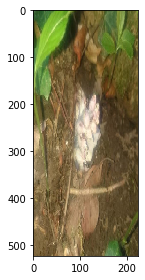

Phyllanthus_epiphyllanthus


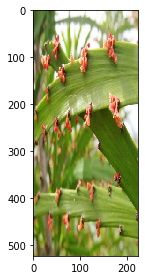

Punica_granatum


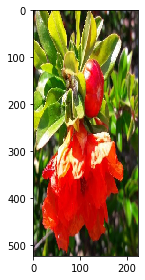

Liriodendron_tulipifera


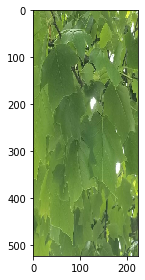

Hypericum_perforatum


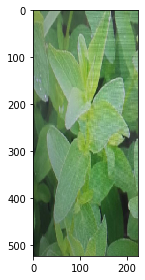

Mercurialis_annua


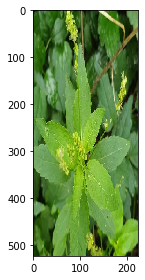

Lavandula_angustifolia


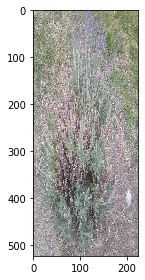

Sedum_acre


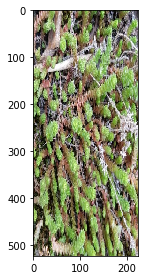

Hypericum_perforatum


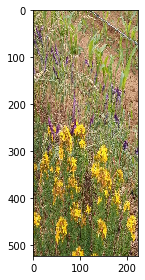

Smilax_aspera


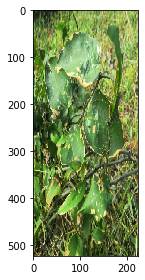

Adonis_aestivalis


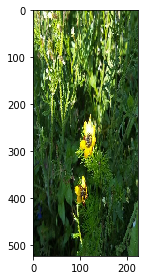

In [144]:
from skimage import io

def imshow(image_RGB):
  io.imshow(image_RGB)
  io.show()

x,y = train_dataset.next()
print("Image Sizes: " +str(x.shape[0]))

for i in range(0,11):
    image = x[i]
    print(class_list[np.argmax(y[i])])
    imshow(image)

## Create Model Base from MobileNetV2 without top layers


In [ ]:
# Mobilenet was originally trained with -1 to +1 values, Normalizer sets images within this range so pretrained weights work properly
# normalizer = tf.keras.layers.experimental.preprocessing.Normalization(mean=0, variance=1)
# inputs = tf.keras.Input(shape=(224,224,3))
# input_layer = normalizer(inputs)
# normalizer.adapt(train_dataset_raw.batch(128))


base_model = tf.keras.applications.MobileNetV2(
    input_shape = (224,224,3),
    alpha=1.0,
    include_top=False,
    weights="imagenet",
    pooling=None,
    classifier_activation="softmax",
)

# Combine input layer with base model
# full_model = Model(inputs=[inputs], outputs=[base_model.output])

## Add Top layer to base model

In [ ]:
# normalizer = tf.keras.layers.experimental.preprocessing.Normalization()
# normalizer.adapt(train_dataset_raw.batch(128))

# inputs = tf.keras.Input(shape=(224,224,3))
# x = normalizer(inputs)
# x = tf.keras.backend.function([x, tf.keras.backend.learning_phase()], base_model.input) 
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation="relu")(x)
predictions = Dense(1081, activation="softmax")(x)

## Finish creating complete model



In [ ]:
# model = Model(inputs = inputs, outputs = predictions)
model = Model(inputs = base_model.input, outputs = predictions)

## Freeze the model middle layers

In [ ]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
# for layer in base_model.layers:
#     layer.trainable = False
base_model.trainable = True


In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.01)
# opt = "rmsprop"
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics= ["accuracy", 'top_k_categorical_accuracy'])

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [ ]:
# Callbacks

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime 

TRAINABLE = True

try:
  TRAINABLE = True if base_model.trainable else False
except:
  pass


current_time = datetime.now().strftime('%Y-%m-%d_%H:%M:%S')
gdrive_dir = "/content/drive/MyDrive/saved_models/"
filepath = "{}plantNet_20210816{}.h5".format(gdrive_dir, "{}".format("_Trainable" if TRAINABLE else ""))

# Try loading model at filepath to continue training
# If no file exists then it creates a new one
try:
  model = keras.models.load_model(filepath)
  print("Continuing training from checkpoint")
except:
  print("No keras model found at {}, will start training from scratch.".format(filepath))
  filepath = "{0}plantNet_{1}{2}.h5".format(gdrive_dir, datetime.now().strftime('%Y%m%d'), "_Trainable" if TRAINABLE else "")
  print("New model filename is {}".format(filepath))


# Save model only when validation accuracy increases
# checkpoint = ModelCheckpoint(filepath, monitor="val_acc", verbose=1, save_best_only=True, mode="max")
checkpoint = ModelCheckpoint(filepath, save_best_only=False, save_weights_only=False)

# Tensorboard callback
logdir = gdrive_dir + "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# Stop training model if validation loss does not improve for 3 epochs
earlyStopping = EarlyStopping(monitor="val_loss", patience=3, verbose=1)

callbacks_list = [checkpoint, earlyStopping, tensorboard_callback]

In [ ]:
gdrive_dir + "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

## Train Model

In [ ]:
epochs = 5
steps_per_epoch = None
# val_dataset = None
history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, callbacks=callbacks_list, steps_per_epoch=steps_per_epoch)



In [ ]:
!ls